In [2]:
# in this notebook we copy embedd matrix from GPT2 into model 1
import numpy as np
import matplotlib.pyplot as plt
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# GPT2's tokenizer
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [4]:
n_vocab = 50257 # GPT2 vocab size
embed_dim = 768   # bcoz GPT2 embedd size is 768
seq_len = 256
n_heads = 12
n_blocks = 12
batch_size= 16
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [5]:
# dowload and tokenize text
text = requests.get('https://www.gutenberg.org/cache/epub/829/pg829.txt').text
gtTokens = torch.tensor(tokenizer.encode(text))
len(gtTokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (158345 > 1024). Running this sequence through the model will result in indexing errors


158345

In [8]:
uniq, counts = np.unique(gtTokens, return_counts=True)
print(f'{len(gtTokens):,} total tokens and {len(uniq):,} unique tokens')
print(f"That is {100*len(uniq)/tokenizer.vocab_size:.1f}% of tokenizer vocab")

158,345 total tokens and 10,273 unique tokens
That is 20.4% of tokenizer vocab


In [9]:
counts

array([12,  1,  2, ...,  1,  6,  1], shape=(10273,))

FInd the 100 most common, least common and unused tokens

In [15]:
a=[10,30,5,20,5]
unqi, c= np.unique(a, return_counts=True)
print(c)
np.argsort(a)

[2 1 1 1]


array([2, 4, 0, 3, 1])

In [19]:
unqi

array([ 5, 10, 20, 30])

In [32]:
freqidx = np.argsort(counts)[::-1]

# most and least common
mostcommon = freqidx[:100]
leastcommon = freqidx[-100:]

# tokens in the dict that dont appear in the text
neverused = []
i=0
while len(neverused)<100:
    if i not in gtTokens:
        neverused.append(i)
    i+=1

In [33]:
mostcommon

array([   5,   70,   71,   84,  108,  112,  106,    7,  136,   79,  109,
         19,  418,  192,  148,  312,  172,  176,  279,  233,  151,  350,
        262,  161,  129,  357,  160,  198,  211,  321,  224,  296,   59,
        288,  354,   41,  141,  140,  333,  239,  409,   76,  289,  244,
        240,  863,  500,    6,  367, 1679,   77,  419, 2957,  103,   18,
         72,  207,   75,  474,  370,  607,  773,  452,  318,  201,  400,
        389,  338, 1203,  353,  518,   29,  582,  313,  320,  677,  177,
        467,  210,  638, 3283,  653,  443, 1091,  423,  420,  410,  639,
        587, 7314,  472,  392, 1310,   38,  327,  439,   81,  413,  825,
        494])

In [34]:
torch.tensor([5])

tensor([5])

In [35]:
tokenizer.decode(torch.tensor([uniq[5]]))

','

In [36]:
# print some examples
print('20 most common tokens:')
for i in mostcommon[:20]:
    print(f' {counts[i]:4} occurences "{tokenizer.decode(torch.tensor([uniq[i]]))}"')

# print some examples
print('20 LEAST common tokens:')
for i in leastcommon[:20]:
    print(f' {counts[i]:4} occurences "{tokenizer.decode(torch.tensor([uniq[i]]))}"')

# print some examples
print('20NEVER USEd tokens:')
for i in neverused[:20]:
    print(f' {len(np.where(gtTokens==i)[0])} occurences "{tokenizer.decode(torch.tensor([i]))}"')

20 most common tokens:
 10060 occurences ","
 9919 occurences "
"
"9919 occurences "
 5393 occurences " the"
 3779 occurences " of"
 3467 occurences " and"
 3356 occurences " to"
 3004 occurences "."
 2657 occurences " I"
 2431 occurences " a"
 1900 occurences " in"
 1562 occurences ";"
 1474 occurences " my"
 1199 occurences " was"
 1061 occurences " that"
  964 occurences " me"
  941 occurences " with"
  920 occurences " as"
  823 occurences " his"
  794 occurences " by"
20 LEAST common tokens:
    1 occurences " beam"
    1 occurences " Swift"
    1 occurences " expose"
    1 occurences "letters"
    1 occurences "eff"
    1 occurences "amy"
    1 occurences "Port"
    1 occurences " skip"
    1 occurences " ic"
    1 occurences "ARK"
    1 occurences " comparing"
    1 occurences " safer"
    1 occurences " statute"
    1 occurences "hal"
    1 occurences "Sur"
    1 occurences " accusations"
    1 occurences "atched"
    1 occurences "stat"
    1 occurences "imb"
    1 occurences 

Now we have 3 categories as shown above (mostcommon, least common and never used)

We will now compare anmd finmd its avg logsoftmax in a random model (model5)

In [37]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        
        super().__init__()
    
        #head dimensionality is embed_dim split across the heads
        self.num_heads = n_heads
        self.head_dim = embed_dim // n_heads
    
        # the three Q,K,V weight matrices are init as one, and are split inside attention eqn
        self.QKV = nn.Linear(embed_dim, 3*embed_dim, bias=True)
    
        #final linear projection merges the heads outputs
        self.W0 = nn.Linear(embed_dim, embed_dim, bias=True)
    
    def forward(self, x):
        # extract the dimension size of the inputs(token embedds)
        B, T, E = x.shape # [batch, tokens (or seq_len), embed_dim]
        

        #push data through Q,K and V in one concatenated matrix
        qkv = self.QKV(x) #[batch, seq_len, 3*embed]
        q,k,v = torch.split(qkv, E, dim=2) # each matrix is [B,T,E]

        # reshape to [B,T,nHeads, head_dim]
        # and then transpose to [B, nHeads, T, head_dim]
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1,2) #[B, num_heads, T, head_dim]
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1,2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1,2)

        # Pytorchs SDPA func handles multi head shapes
        out = F.scaled_dot_product_attention(q,k,v,is_causal=True)

        # recombine heads : (B,nHeads,T,head_dim) -> [B,T,E]
        out = out.transpose(1,2).reshape(B,T,E)
    

        #finallt apply linear mixing matrix
        out = self.W0(out)

        return out

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()

        #attention subblock
        self.layernorm_1 = nn.LayerNorm(embed_dim,eps=1e-5)
        self.attn = MultiHeadAttention()

        #feedfwd (MLP) sublayer
        self.layernorm_2 = nn.LayerNorm(embed_dim,eps=1e-5)
        self.mlp_1 = nn.Linear(embed_dim,4*embed_dim,bias=True) # 4x expansion
        self.gelu = nn.GELU()
        self.mlp_2 = nn.Linear(4*embed_dim, embed_dim, bias=True) #4x contraction

    def forward(self,x):

        ## ----attention sublayer ------##
        x_att = self.layernorm_1(x) # pre attn normalisn
        x_att = x + self.attn(x_att) # run through attention, then add pre attn activations

        #MLP
        x_ff = self.layernorm_2(x_att) # pre MLP normlsn
        x_ff = x_att + self.mlp_2( self.gelu( self.mlp_1(x_ff)))
        
        return x_ff
        
        

In [38]:
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()

        # token + posn embedds
        self.wte = nn.Embedding(n_vocab, embed_dim) # token embedds
        self.wpe = nn.Embedding(seq_len, embed_dim) # posn embedds

        #n mutliple Transformer blocks
        # * is a unpacking operator, the list of txf blocks goes into input of Sequential()
        self.transformerBlocks = nn.Sequential(*[TransformerBlock() for _ in range(n_blocks)])

        # embedding to output (linear) layer
        self.layernorm_final = nn.LayerNorm(embed_dim,eps=1e-5) # final layernorm after all txf blocks
        #unembed matirx
        self.final_head = nn.Linear(embed_dim, n_vocab, bias=False)
        #final ouput layer (unembedd) tied to token embedd
        self.final_head.weight = nn.Parameter(self.wte.weight)


        self.apply(self.weightInits) #apply the input func (weightInits) iteratively to all elements of this class
    
    def weightInits(self, module):
        
        # init nn.Linear to normal with std=.02
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0, std=.02)

            # init the bias terms to zero
            if module.bias is not None:
                nn.init.zeros_(module.bias)

        # Init nn.Embeddings to Xavier
        if isinstance(module, nn.Embedding):
            nn.init.xavier_normal_(module.weight)
                
    def forward(self, idx):

        #----------embeddings-------------##
        token_emb = self.wte(idx)  # [B,T,E]   T is seq_len and E is embed_dim
        posit_emb = self.wpe(torch.arange(idx.shape[-1],device=device)) #[seq_len, embed_dim]
        x = token_emb + posit_emb #[B,T,E]
        ##--------------------------------##

        #n
        ##--pass through each transformer blocks----##
        x = self.transformerBlocks(x)
        ##-------------------------##

        #-----finally unembeddings----##
        x = self.layernorm_final(x)
        logits = self.final_head(x) # [B,T, n_vocab]
        # logits is [batch, seq_len, n_vocab]

        outputs = F.log_softmax(logits/np.sqrt(embed_dim),dim=-1)
        # NOTE HERE WE OUTPUT THE LOGSOFTMAX, not logits
        return outputs

# NOTE: WE DONT HAVE GENERATE METHOD OIN THIS EXCERCISE

In [40]:
model = LanguageModel().to(device)

In [42]:
# generate a batch of data
ix = torch.randint(len(gtTokens)-seq_len, size=(batch_size,))
X = gtTokens[ix[:,None]+torch.arange(seq_len)].to(device)

# fwd pass
out = model(X).detach().cpu().numpy()

# create a submatrix of all outputs for this set of words
# from out we take logsoftmax of only common tokens for each batch and each seq
submatrix = out[:,:,mostcommon]

print(f'Size of input: {X.shape}')
print(f'Size of output: {out.shape}')
print(f'Size of submatirx: {submatrix.shape}')

Size of input: torch.Size([16, 256])
Size of output: (16, 256, 50257)
Size of submatirx: (16, 256, 100)


In [43]:
# avg all ouputs
most_ave = out[:,:,mostcommon].mean()
least_ave = out[:,:,leastcommon].mean()
never_ave = out[:,:,neverused].mean()

print(f'{most_ave:.2f} for most common')
print(f'{least_ave:.2f} for least common')
print(f'{never_ave:.2f} for unused')

-10.83 for most common
-10.83 for least common
-10.82 for unused


In [44]:
# but above calc include model outputs to the actual tokens in mostcommon,
# we dont want to include the tokens in input data X
Xflat = X.view(-1).cpu().numpy()

#extarct a submatrix and flaten
submatrix = out[:,:,mostcommon]
subflat = submatrix.reshape(batch_size*seq_len,-1)

# filter using boolean indezxing
mask = ~np.isin(Xflat, mostcommon) # mask for gfiltering
data2ave = subflat[mask,:] # select only non-comon token outputs

print(f'Size of input: {Xflat.shape}')
print(f'Size of output: {out.shape}')
print(f'Size of submatirx: {submatrix.shape}')
print(f'Size of flattend submatirx: {subflat.shape}')


Size of input: (4096,)
Size of output: (16, 256, 50257)
Size of submatirx: (16, 256, 100)
Size of flattend submatirx: (4096, 100)


Now track category log softmax during training

In [46]:

# create loss and omptimizer funcitons
loss_function = nn.NLLLoss(reduction='mean').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=.001, weight_decay=.01)  

In [48]:
num_samples = 501
tokenProbs = np.zeros((num_samples,3))
#init the loss
train_loss = []

for sampli in range(num_samples):
    # get batch of data
    ix = torch.randint(len(gtTokens)-seq_len, size=(batch_size,))
    X =  gtTokens[ix[:,None]+torch.arange(seq_len)]
    y =  gtTokens[ix[:,None]+torch.arange(1,seq_len+1)]

    X,y = X.to(device), y.to(device)
    
    model.zero_grad(set_to_none=True)

    #fwd pass
    logProbs = model(X)
    log_probs_flat = logProbs.view(-1,logProbs.shape[-1])  #tokens 0:N-1
    y_flat = y.view(-1) # tokens 1:N
    loss = loss_function(log_probs_flat,y_flat)
    # loss = loss_function(log_probs.view(-1, log_probs.shape[-1]),y.view(-1))

    #bckprop
    loss.backward()
    optimizer.step()

    # sum the batch loss
    train_loss.append(loss.item())


    # calculate outputs for token freq category
    # flatten the model inpout and outputs
    Xflat = X.view(-1).cpu().numpy()
    outs = logProbs.detach().cpu().numpy()

    # MOSTCOMMON tokens: extract submatrix and avg tokens not in train data
    submatrix = out[:,:,mostcommon].reshape(batch_size*seq_len,-1)
    mask = ~np.isin(Xflat, mostcommon) # mask for gfiltering
    tokenProbs[sampli,0] = submatrix[mask,:].mean()

    
    # LEAST COMMON tokens: extract submatrix, and avg tokens not in train data
    submatrix = out[:,:,leastcommon].reshape(batch_size*seq_len,-1)
    mask = ~np.isin(Xflat, leastcommon) # mask for gfiltering
    tokenProbs[sampli,1] = submatrix[mask,:].mean()

    # UNUSED TOKENS: extract submatrix, and avg tokens not in train data
    submatrix = out[:,:,neverused].reshape(batch_size*seq_len,-1)
    mask = ~np.isin(Xflat, neverused) # mask for gfiltering
    tokenProbs[sampli,2] = submatrix[mask,:].mean() 
    
    
    
    if sampli%100==0:
        print(f'Sample {sampli} train loss: {train_loss[-1]:.4f}')

Sample 0 train loss: 10.8250
Sample 100 train loss: 7.1760
Sample 200 train loss: 6.2304
Sample 300 train loss: 6.1869
Sample 400 train loss: 5.7086
Sample 500 train loss: 5.4737


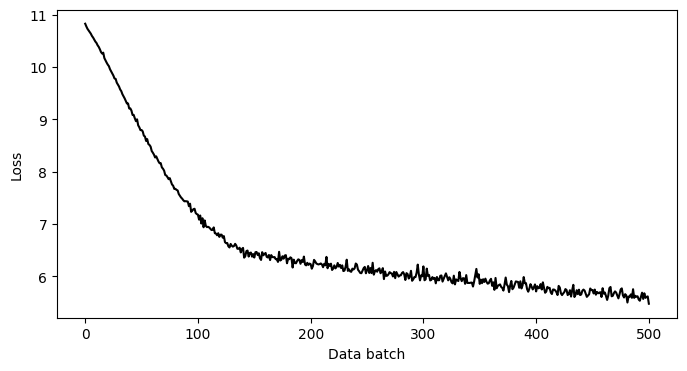

In [52]:
# plot the losses
plt.figure(figsize=(8,4))
plt.plot(train_loss,'k', markersize=8)
plt.gca().set(xlabel='Data batch', ylabel='Loss')
plt.show()

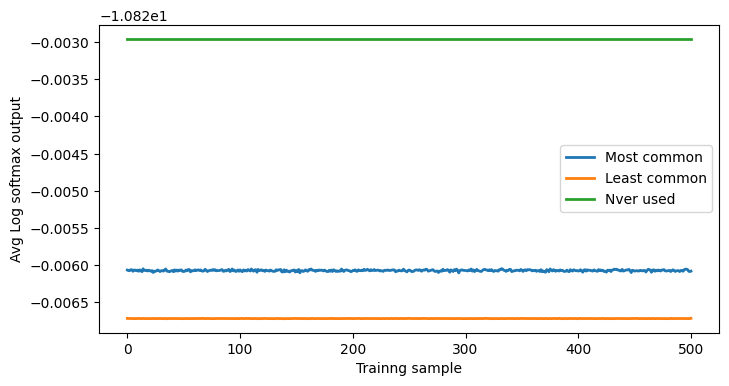

In [53]:
plt.figure(figsize=(8,4))
plt.plot(tokenProbs, linewidth=2)
plt.legend(['Most common', 'Least common','Nver used'])
plt.gca().set(xlabel='Trainng sample',ylabel='Avg Log softmax output')
plt.show()

SO the graph shows that all the tokens are -ve (bcozz we filtered for tokens not selected by model)

But the never used tokens were supressed the most

and then leastcommon were supressed

and less supressed is the most commonones